# Customer Review Analysis


We are going to analyze Olist's E-Commerce dataset aiming to extract value from customer reviews. 

### Data Exploration

In [19]:
import random
from PIL import Image
from datetime import datetime
import unicodedata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import warnings
import seaborn as sns
import nltk
warnings.filterwarnings('ignore')
import matplotlib as mpl
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)
from wordcloud import WordCloud

COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

In [2]:
data = pd.read_csv('data/olist_order_reviews_dataset.csv')
data.head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [3]:
data['review_comment_length'] = data['review_comment_message'].str.len()
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_length
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,NaN
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,NaN
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,NaN
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,37.0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,100.0


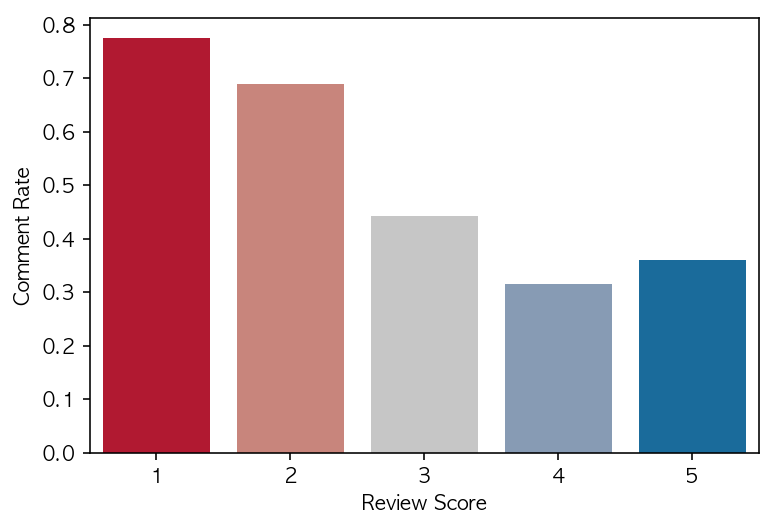

In [4]:
def comment_rate(df):
    return df['review_comment_length'].count() / len(df)

comment_rates = data.groupby('review_score').apply(comment_rate)
sns.barplot(
    comment_rates.index, 
    comment_rates.values, 
    palette=REVIEWS_PALETTE
).set(xlabel='Review Score', ylabel='Comment Rate');

It looks like unhappy customers are more likely to write comments.

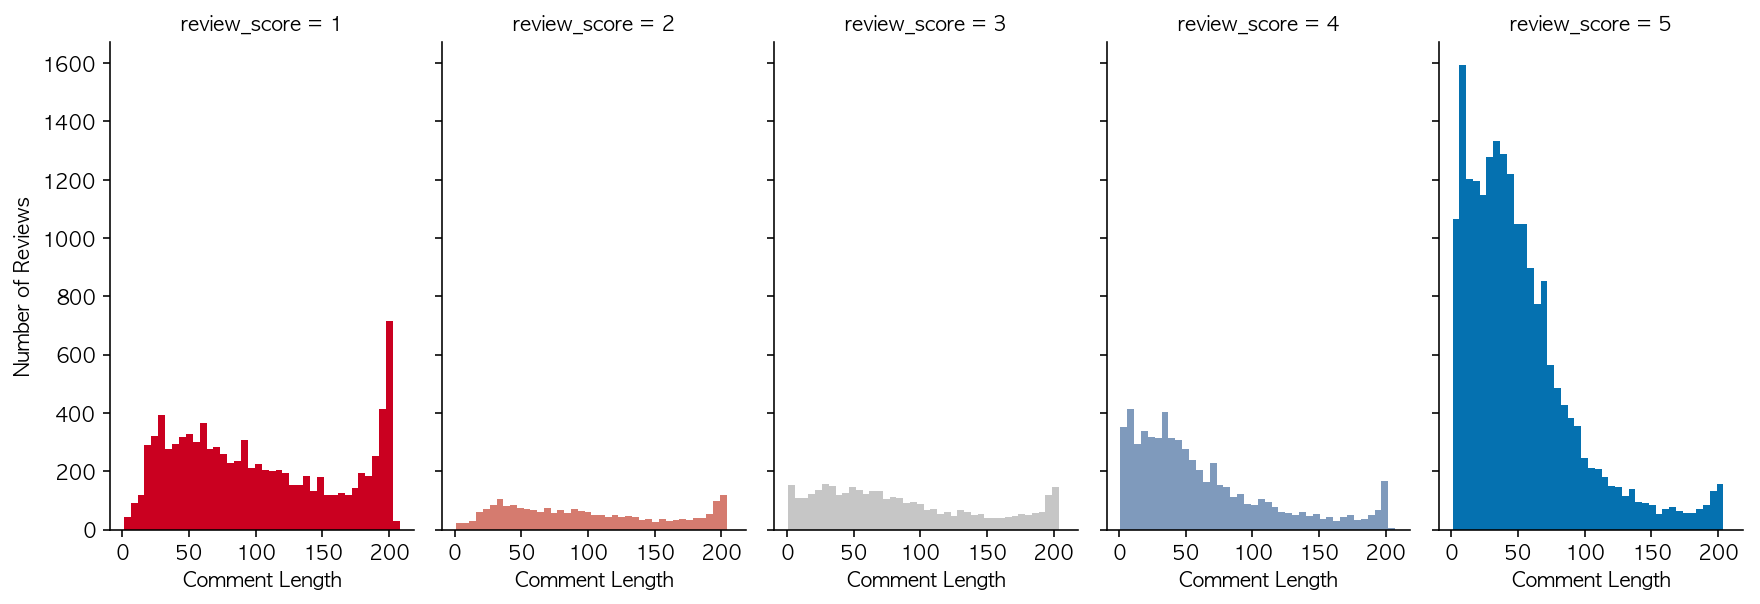

In [5]:
g = sns.FacetGrid(data=data, col='review_score', hue='review_score', palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_comment_length', bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(12, 5)

In [6]:
data = data[['review_comment_message', 'review_score', 'review_comment_length']].dropna()
data.head()

,review_comment_message,review_score,review_comment_length
3,Recebi bem antes do prazo estipulado.,5,37.0
4,Parabéns lojas lannister adorei comprar pela I...,5,100.0
9,aparelho eficiente. no site a marca do aparelh...,4,174.0
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,45.0
15,"Vendedor confiável, produto ok e entrega antes...",5,56.0


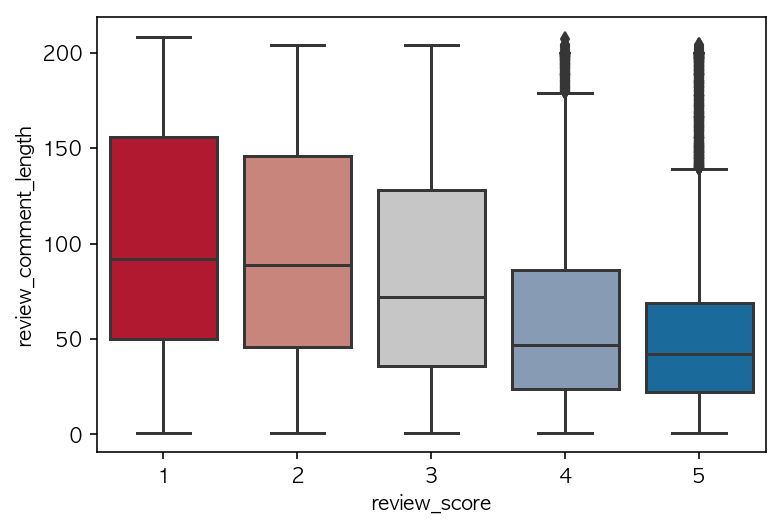

In [7]:
sns.boxplot(x='review_score', y='review_comment_length', data=data, palette=REVIEWS_PALETTE)

Bad review scores has bigger length of review comments

## Natural Language Processing

In [8]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
STOP_WORDS.remove('nao') # This word is key to understand delivery problems later


def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))
    
    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)


In [9]:
commented_reviews = data.copy()
commented_reviews['review_comment_words'] = commented_reviews['review_comment_message'].apply(comments_to_words)

reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

### Review Comments (Review Score=5)

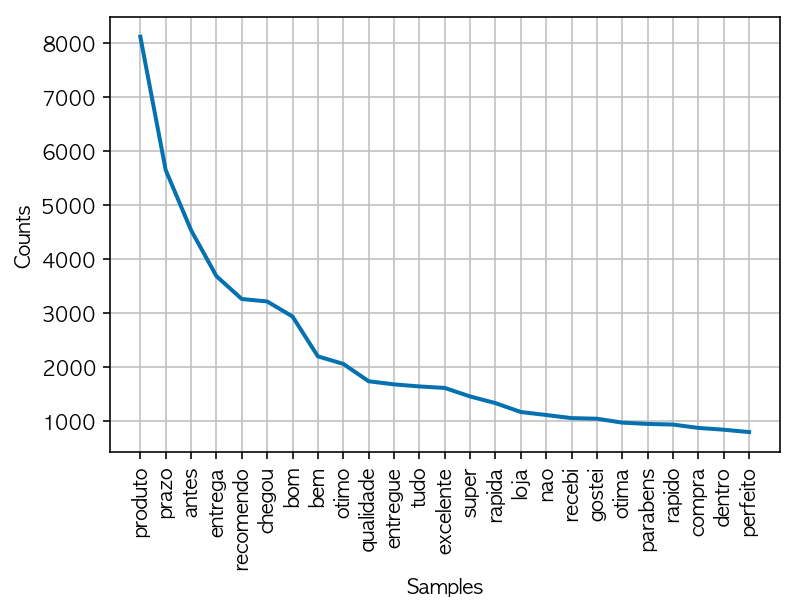

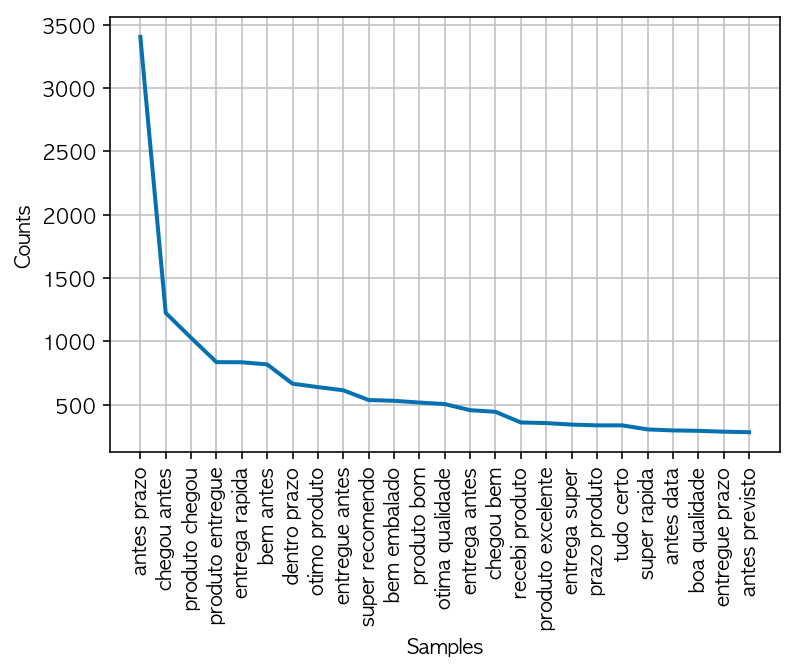

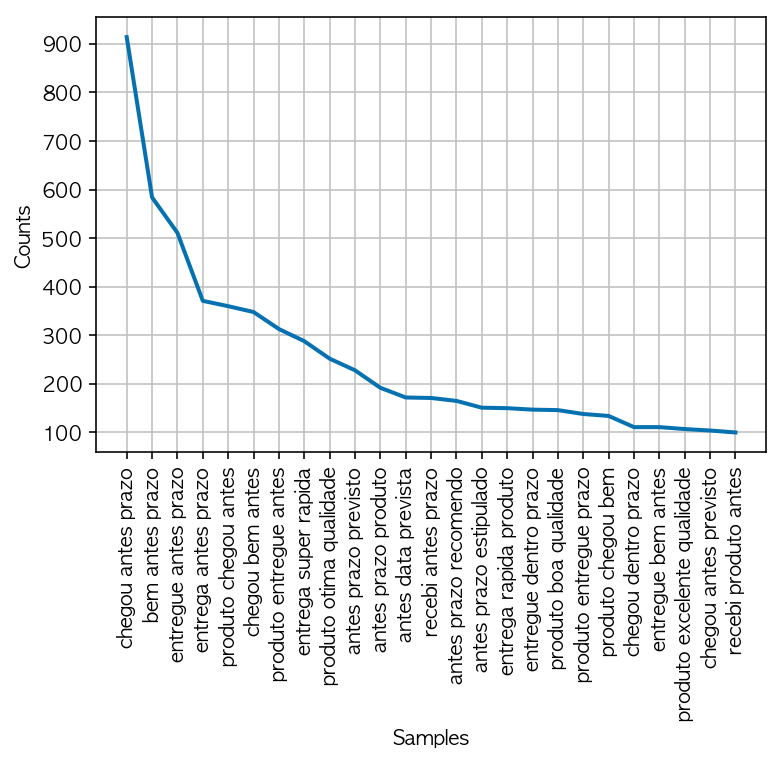

In [10]:
plot_freq(unigrams_5s, COLOR_5S)
plot_freq(bigrams_5s, COLOR_5S)
plot_freq(trigrams_5s, COLOR_5S)

Olist's customers(review score=5) enjoy about their experience:

* Fast delivery ('chegou antes prazo', 'entrega rapida', 'entregue antes prazo', 'super rapida')
* High quality goods ('produto otima qualidade', 'otimo produto', 'produto excelente', 'produto boa qualidade')
* Good packaging ('bem embalado', 'produto chegou bem')

### Review Comments (Review Score=1)

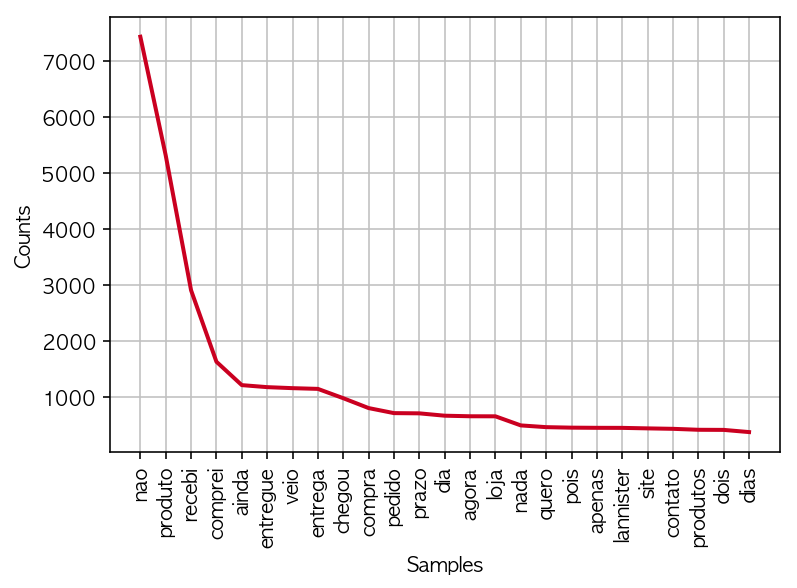

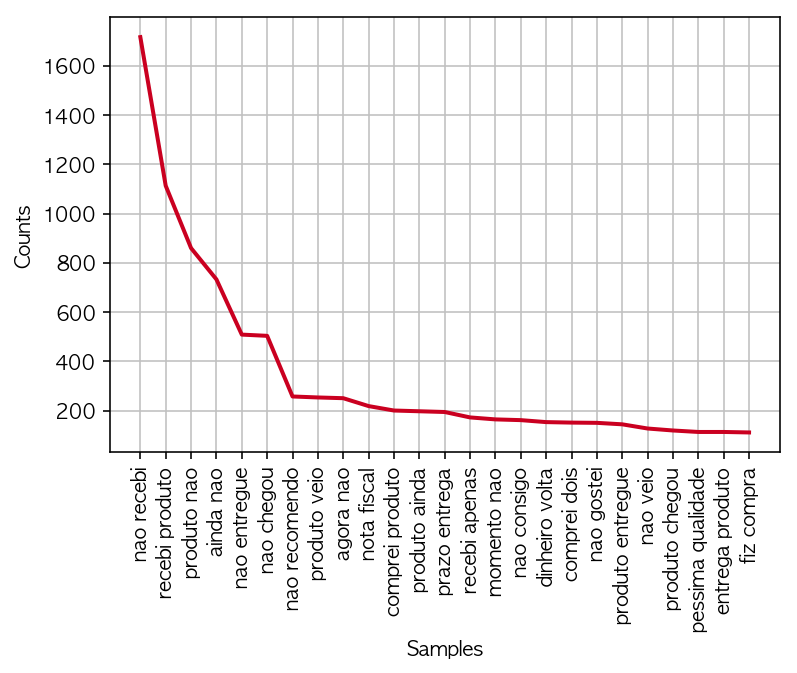

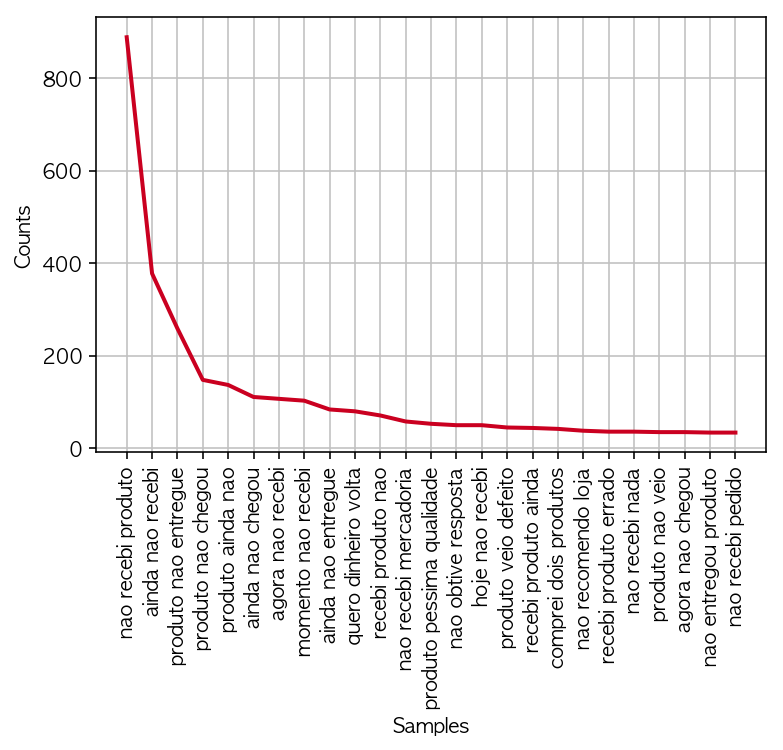

In [11]:
plot_freq(unigrams_1s, COLOR_1S)
plot_freq(bigrams_1s, COLOR_1S)
plot_freq(trigrams_1s, COLOR_1S)


Olist's customers(review score=1)were dissatisfied with their experience:

* They received the wrong goods ('recebi produto errado', 'produto veio errado', 'produto totalmente diferente')
* Some customers received fake items('produto nao original')
* People rate seller's customer service badly, which seems to be unresponsive in some cases
* Some people didn't receive their invoices

## Clustering Customer Comments

### Vectorization

Use Tf-idf method

In [12]:
review = data[['review_comment_message']].copy()
review.head()


,review_comment_message
3,Recebi bem antes do prazo estipulado.
4,Parabéns lojas lannister adorei comprar pela I...
9,aparelho eficiente. no site a marca do aparelh...
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,"Vendedor confiável, produto ok e entrega antes..."


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100, ngram_range=(2, 4), stop_words=stopwords.words('portuguese'))
vectorizer.fit(review['review_comment_message'])
X = vectorizer.transform(review['review_comment_message'])

### Dimensionality reduction

Becaues of a lot of features, Let's use PCA(Principal Component Analysis) to reduce the dimensionality

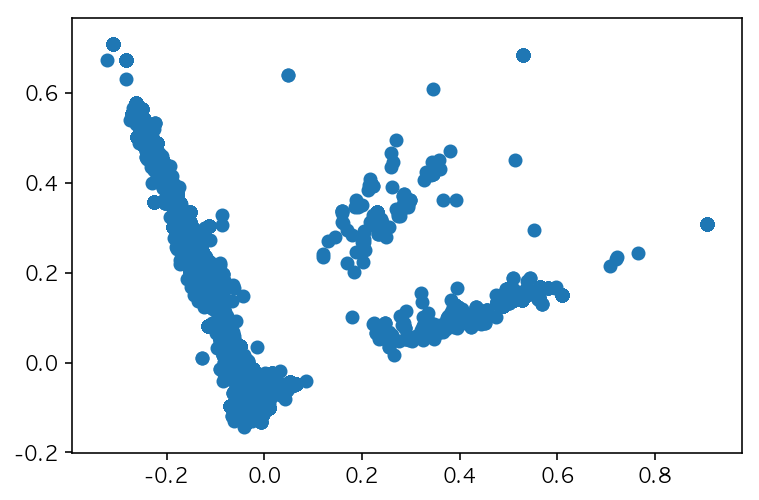

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())
plt.scatter(X_pca[:,0], X_pca[:,1])

### Clustering

Due to the shape of our data maybe K-means isn't a good option, let's try to use a AgglomerativeClustering available in Scikit-Learn:

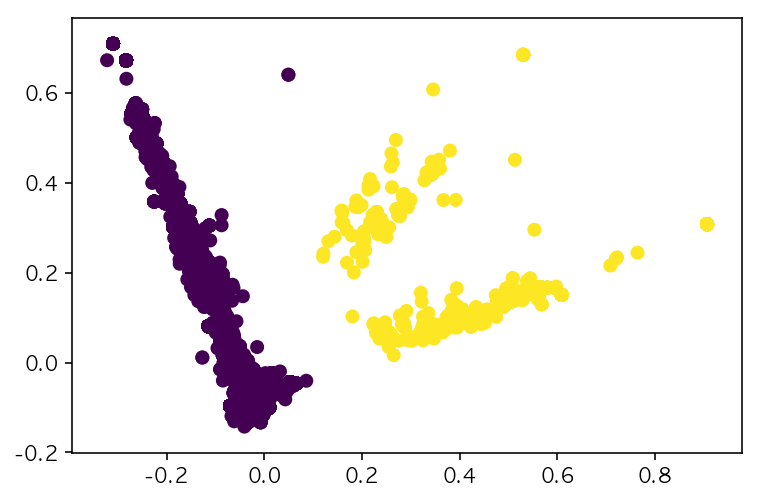

In [15]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=2)
predicted = model.fit_predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted)

In [16]:
review['predicted'] = predicted
review['predicted'].value_counts()


0    39824
1     1929
Name: predicted, dtype: int64

([<matplotlib.axis.XTick at 0x1a346452b0>,
 <a list of 2 Text xticklabel objects>)

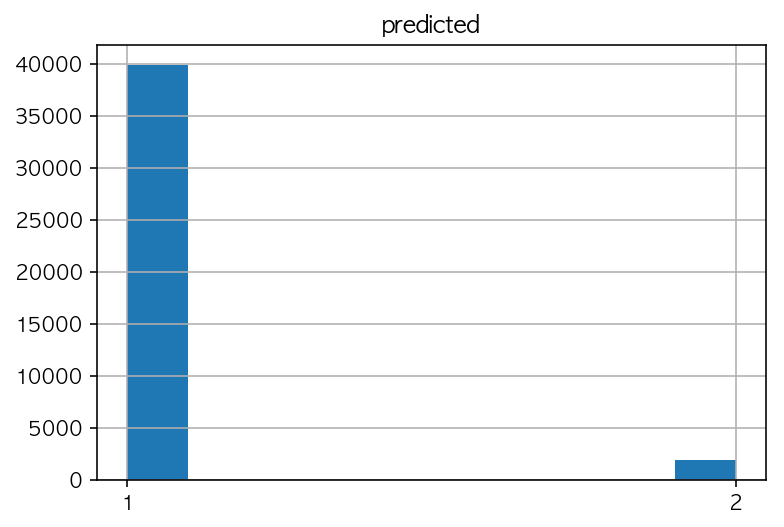

In [17]:
review[['predicted']].hist()
plt.xticks(np.arange(2), np.arange(1, 3))

### Word Clouds of the Clusters

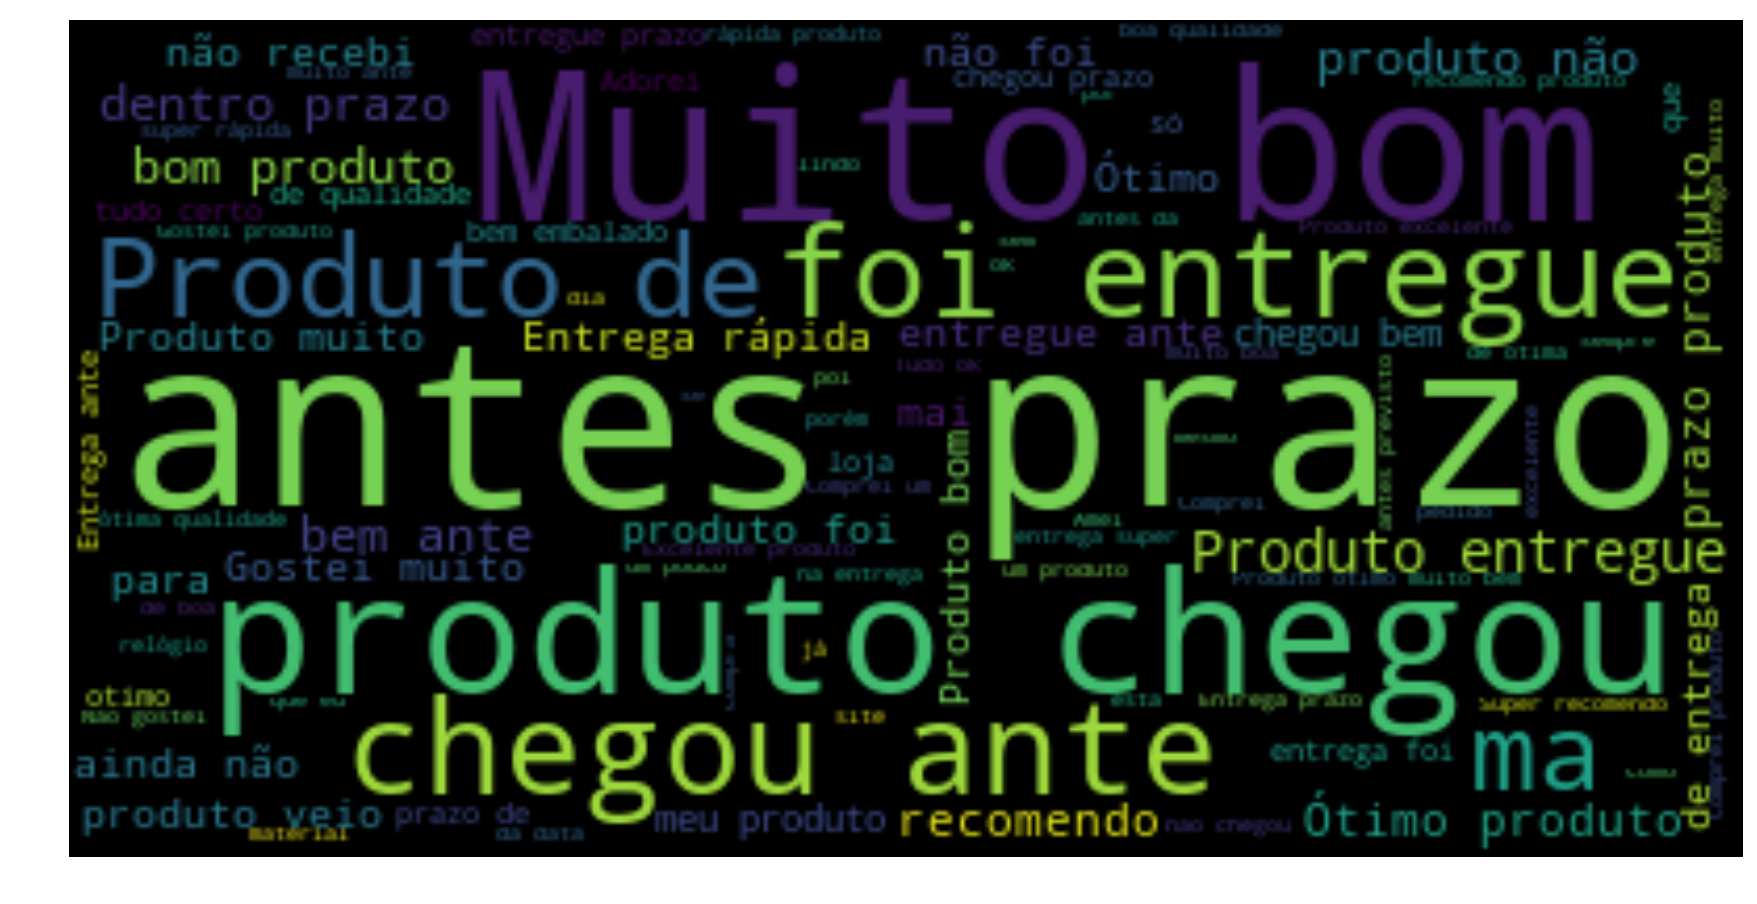

In [20]:
text = review[review['predicted'] == 0]['review_comment_message'].to_string()

wordcloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

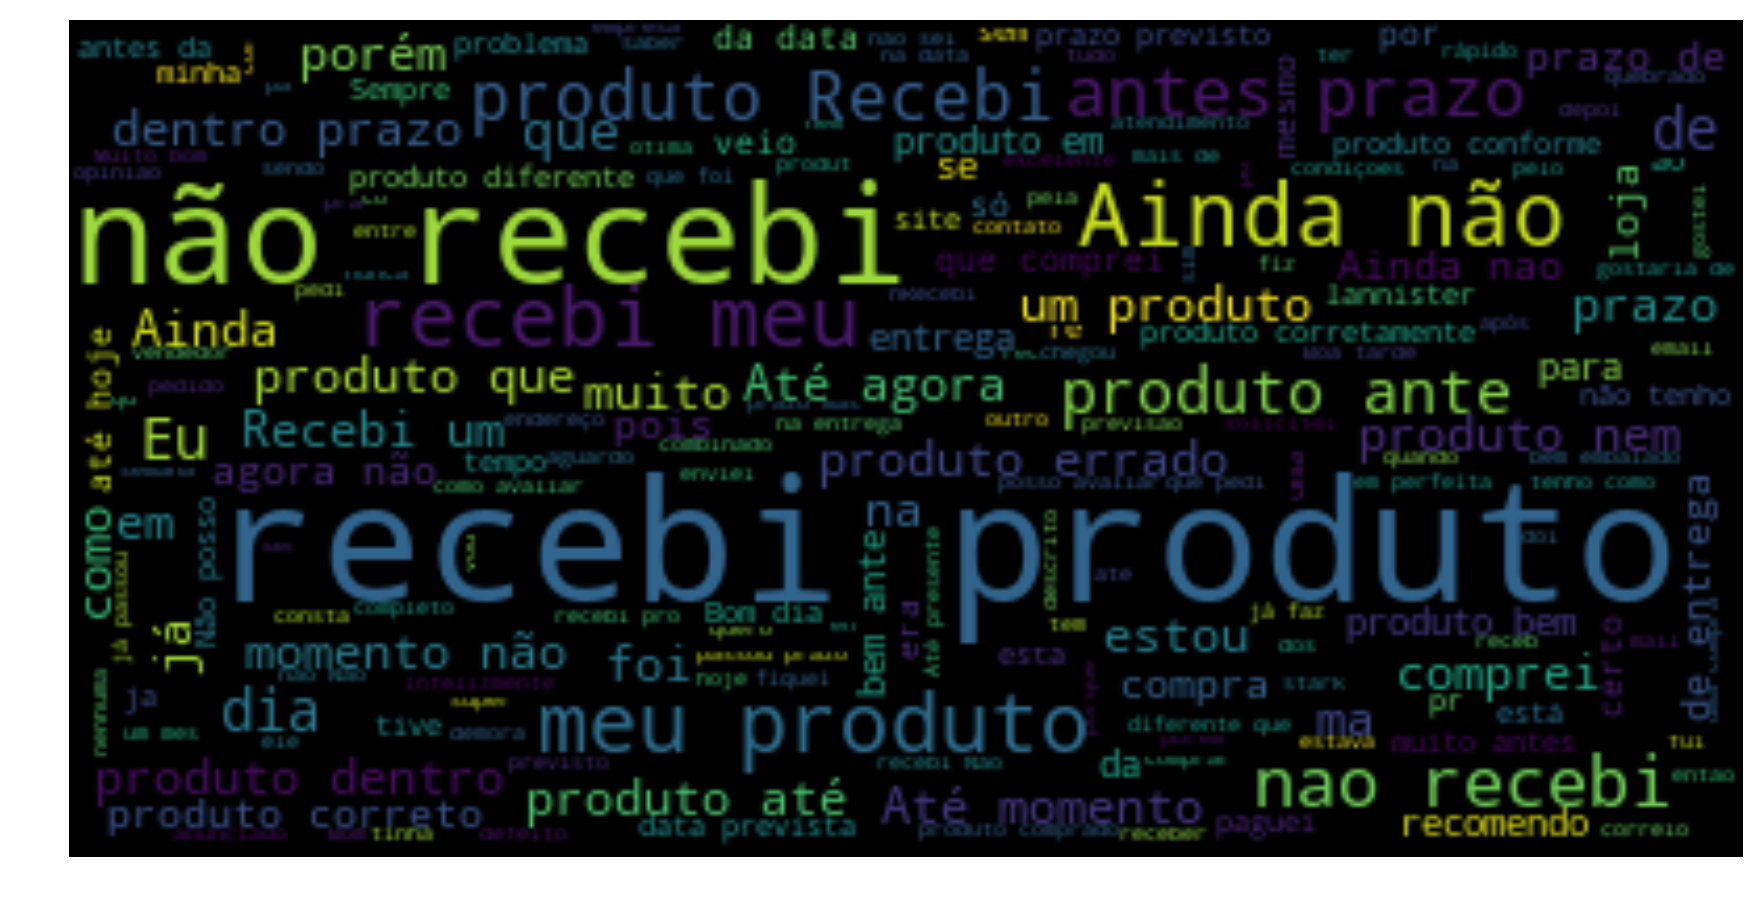

In [21]:
text = review[review['predicted'] == 1]['review_comment_message'].to_string()

wordcloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");


Looking at the word clouds we can see that the delivery time is very important for the customers. The first cluster looks like good reviews that shows compliments and contentment mainly related to the early delivery of the products. On the other hand the second cluster shows discontentment about delays in delivery and in some cases the wrong product beeing delivered but the delays still are majority.

This shows that the delivery is something that the seller have to pay extra attention, always looking for a transporter that has low rate of delay and in most cases delivery early than the estimated.